In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
pos_score_dict = {
    'Guard': 1,
    'Forward': 2,
    'Center': 3
}

player_df = pd.read_csv('./player-shoes-data.csv')
player_df['pos_score'] = player_df['Position'].apply(lambda x: pos_score_dict[x])
player_df

,Player,Player Page Link,Current Kicks,Position,pos_score
0,Precious Achiuwa,https://ballershoesdb.com/players/precious-ach...,Anta Daringly 3.0,Forward,2
1,Steven Adams,https://ballershoesdb.com/players/steven-adams/,New Balance Two Wxy V3,Center,3
2,Bam Adebayo,https://ballershoesdb.com/players/bam-adebayo/,Air Jordan 37,Forward,2
3,Santi Aldama,https://ballershoesdb.com/players/santi-aldama/,Nike Kyrie Low 5,Forward,2
4,Nickeil Alexander-Walker,https://ballershoesdb.com/players/nickeil-alex...,Nike Kobe 5 Protro,Guard,1
...,...,...,...,...,...
441,Thaddeus Young,https://ballershoesdb.com/players/thaddeus-young/,Nike Kobe 6 Protro,Forward,2
442,Trae Young,https://ballershoesdb.com/players/trae-young/,Adidas Trae Young 2,Guard,1
443,Omer Yurtseven,https://ballershoesdb.com/players/omer-yurtseven/,Nike Kobe 5 Protro,Center,3
444,Cody Zeller,https://ballershoesdb.com/players/cody-zeller/,Air Jordan 37,Center,3


In [3]:
import re
shoes_df = pd.read_csv('shoe-metadata.csv')
shoes_df['Number'] = shoes_df['Shoe Tag'].apply(lambda x: re.search(r'shoe_(\d+)\.jpg', x).group(1))
merged_df = shoes_df.merge(player_df, how='left', left_on='Shoe Name', right_on='Current Kicks')
merged_df = merged_df.dropna(subset=['Player'])
grouped_df = merged_df.groupby(['Number', 'Shoe Tag', 'Shoe Name']).agg({'Player': 'count', 'pos_score': 'mean'}).reset_index()
# filtered_df = grouped_df[grouped_df['Player'] > 1]
sorted_df = grouped_df.copy()
sorted_df['Number'] = sorted_df['Number'].astype(int)
sorted_df = sorted_df.sort_values(by='Number')
shoe_files = list(sorted_df['Shoe Tag'].unique())
shoe_names = [x.replace('.jpg', '') for x in shoe_files]
shoe_pos_dict = sorted_df[['Shoe Tag', 'pos_score']].set_index('Shoe Tag').to_dict(orient='index')
print(len(shoe_files), shoe_names[:5])

136 ['shoe_1', 'shoe_3', 'shoe_7', 'shoe_10', 'shoe_11']


In [4]:
sorted_df.sort_values(by='pos_score')

,Number,Shoe Tag,Shoe Name,Player,pos_score
49,348,shoe_348.jpg,Nike Ja 1,1,1.0
65,388,shoe_388.jpg,Nike Kyrie Flytrap 6,1,1.0
61,381,shoe_381.jpg,Nike Kyrie 3,2,1.0
59,379,shoe_379.jpg,Nike Kyrie 1,1,1.0
47,340,shoe_340.jpg,Nike Hyperdunk 2017,1,1.0
...,...,...,...,...,...
19,19,shoe_19.jpg,Adidas Crazy Explosive 2017,1,3.0
78,426,shoe_426.jpg,Nike Renew Elevate 3,1,3.0
90,458,shoe_458.jpg,Nike Zoom Kobe 8,1,3.0
125,69,shoe_69.jpg,Adidas Harden Vol. 6,1,3.0


In [5]:
import cv2
import numpy as np

def parse_png_directory(directory):
  """Parses a PNG directory and converts PNG files into NumPy arrays.

  Args:
    directory: The path to the PNG directory.

  Returns:
    A list of NumPy arrays, where each array represents one PNG file.
  """

  png_files = []
  for file in os.listdir(directory):
    if file.endswith(".png") and (file.replace('.png', '') in shoe_names or file.replace('_flipped.png', '') in shoe_names):
      png_files.append(file)

  numpy_arrays = []
  for png_file in png_files:
    numpy_array = cv2.imread(os.path.join(directory, png_file))
    grayscale_image = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2GRAY)
    image_vec = np.reshape(grayscale_image, (-1,))
    numpy_arrays.append(image_vec)

  return np.vstack(numpy_arrays), np.array(png_files)

In [6]:
directory = "./cleaned_images"
images, png_files = parse_png_directory(directory)
images.shape
print(png_files[:10])

['shoe_354_flipped.png' 'shoe_389.png' 'shoe_410.png' 'shoe_404.png'
 'shoe_324_flipped.png' 'shoe_501_flipped.png' 'shoe_571_flipped.png'
 'shoe_202.png' 'shoe_564.png' 'shoe_570.png']


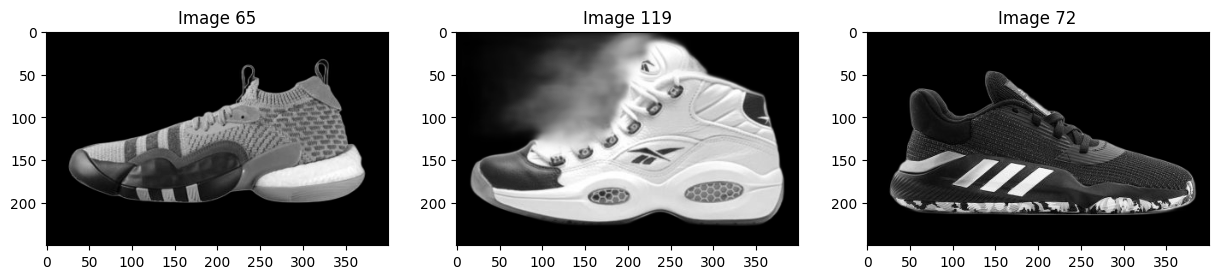

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
random_nums = []
for i, ax in enumerate(axs.flatten()):
    random_num = np.random.choice(range(images.shape[0]))
    random_nums.append(random_num)
    ax.imshow(np.reshape(images[random_num], (250,400)), cmap="gray")
    ax.set_title(f"Image {random_num}")

In [8]:
def get_distance_matrix(W):
    # Assemble weighted edges matrix
    n = np.shape(W)[0]
    G = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            G.add_weighted_edges_from([(i, j, min(W[i,j], W[j,i]))])
    
    # Implement dijkstra's algorithm to get distance matrix
    distances = dict(nx.all_pairs_dijkstra_path_length(G))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = distances[i][j]
    
    return D

In [9]:
def principal_component_analysis(X, k):
     
    #Step 1: standardize the data
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step 2: compute covariance matrix
    C = np.cov(X_meaned , rowvar = False)
     
    #Step 3: find eigengenvalues and eigenvectors using covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(C)
     
    #Step 4: sort eigenvalues to find principal components
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:,sorted_index]
     
    #Step 5: select the top k principal components
    eigenvector_subset = sorted_eigenvectors[:,0:k]
     
    #Step 6: transform principal components for visualization
    X_transformed = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_transformed

In [10]:
N = len(images)

def compute_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))
    
# generate adjacency matrix for nearest neighbor graph
G = np.zeros([N,N])
for i in range(N):
    for j in range(i,N):
        G[i,j] = G[j,i] = compute_distance(images[i], images[j])
        
Z = principal_component_analysis(G, 2)

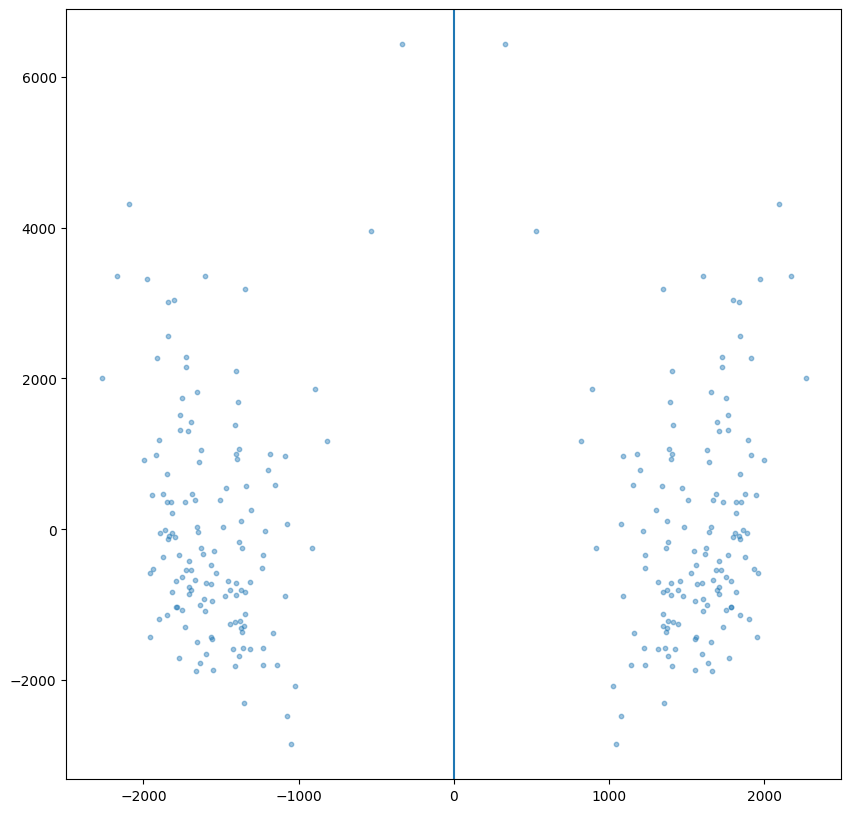

In [11]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(
        Z[:,0], 
        Z[:,1],
        marker="o",
        s=10,
        alpha=0.425,
        zorder=0,
    )
ax.axvline(x=0)

In [12]:
print(Z.shape)
Z_new = Z[Z[:,0] < 0]
images = images[Z[:,0] < 0]
filtered_names = png_files[Z[:,0] < 0]
print(Z_new.shape)

(272, 2)
(136, 2)


In [13]:
pos_scores = []
for name in filtered_names:
    index_str = name.replace('_flipped.png', '.jpg').replace('.png', '.jpg')
    pos_scores.append(shoe_pos_dict[index_str]['pos_score'])

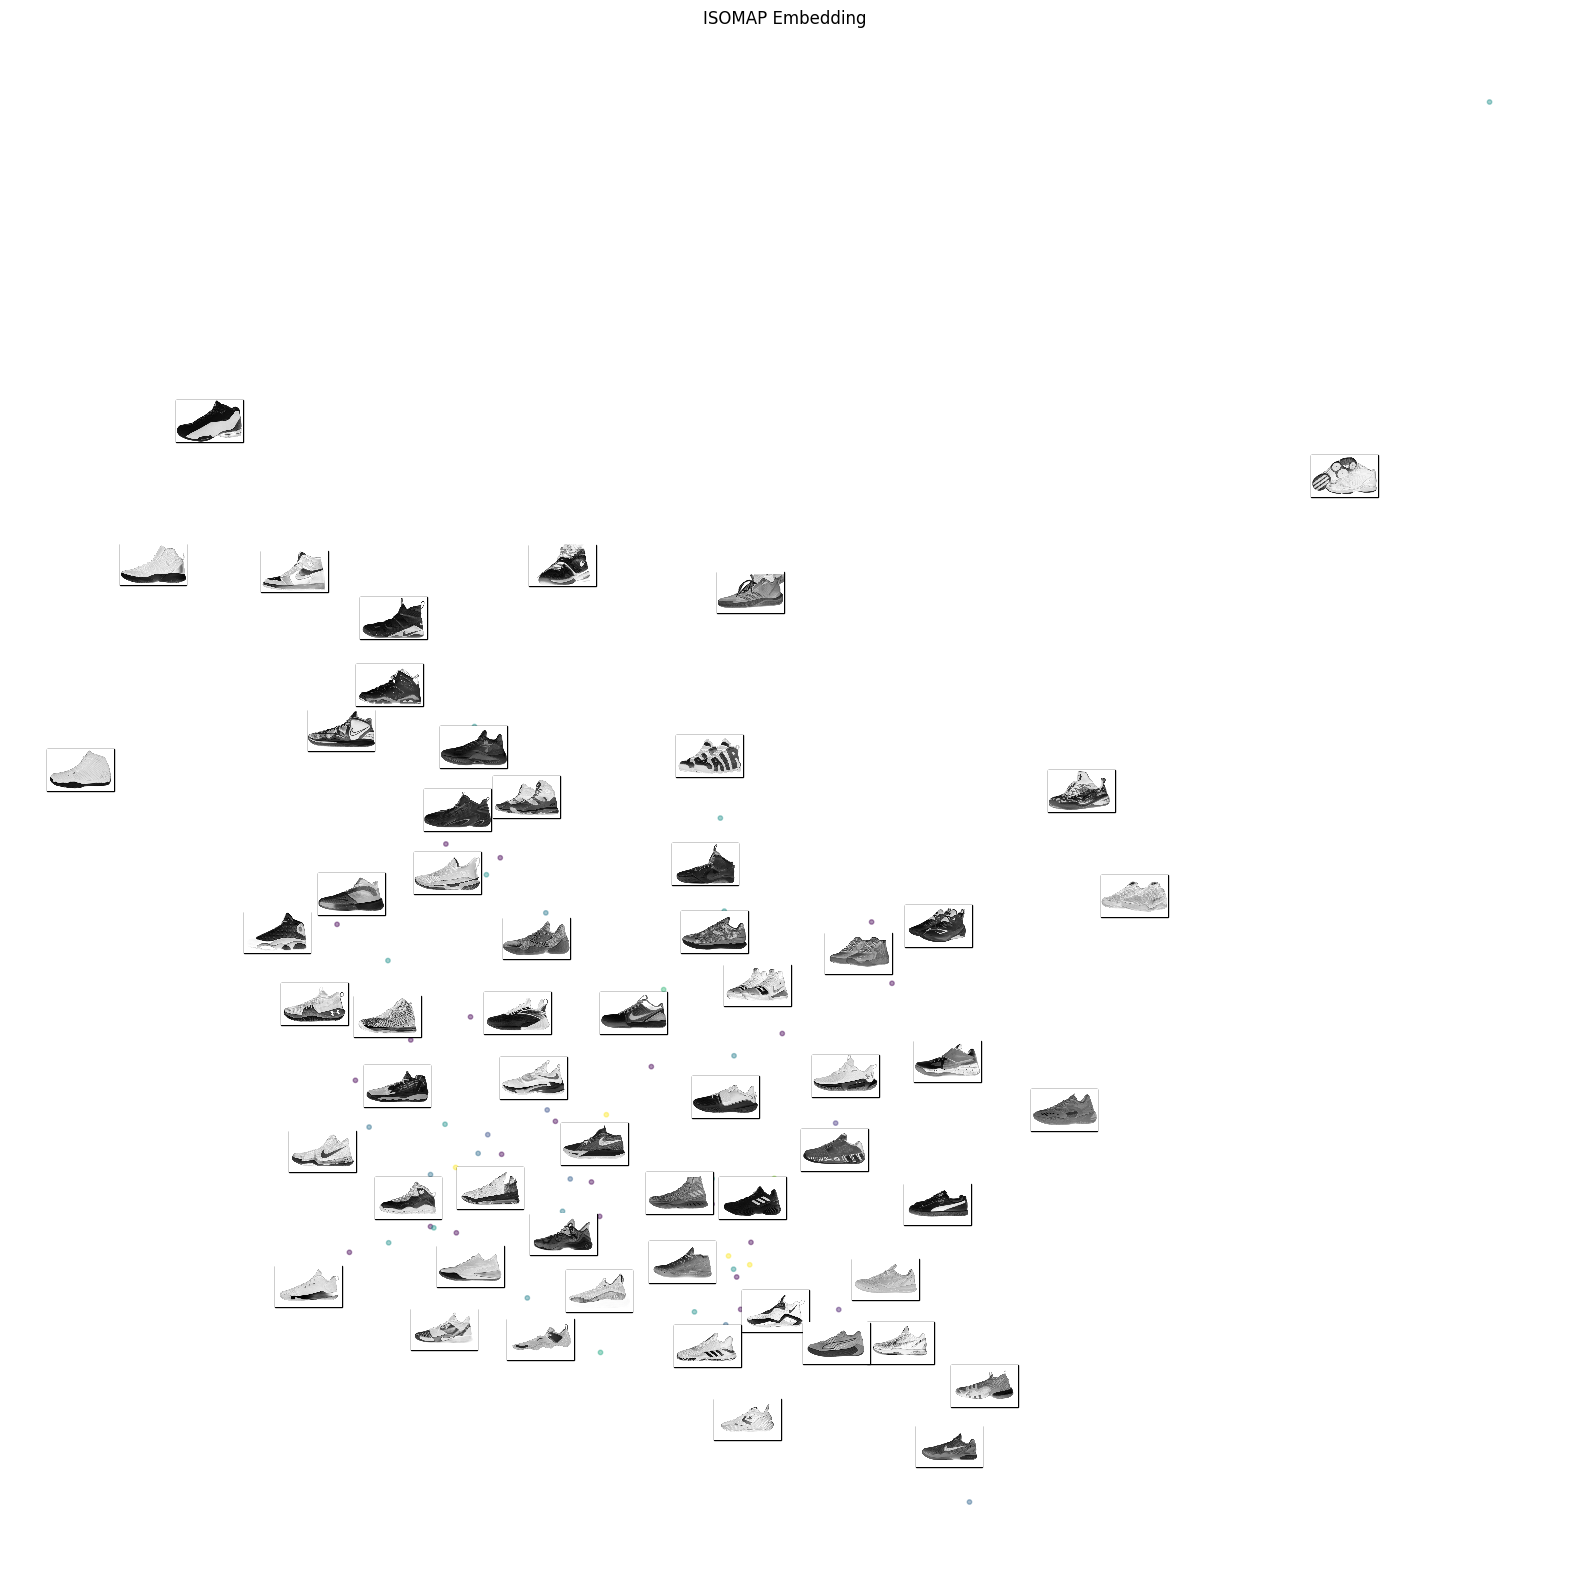

In [14]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

def plot_embedding(X, title):
    _, ax = plt.subplots(figsize=(20,20))
    X = MinMaxScaler().fit_transform(X)

    ax.scatter(
        X[:,0], 
        X[:,1],
        marker="o",
        c=pos_scores,
        cmap=plt.cm.viridis,
        s=10,
        alpha=0.425,
        zorder=0,
    )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(np.reshape(images[i], (250, 400)), zoom=0.12, cmap=plt.cm.gray_r), X[i], pad=0
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

plot_embedding(Z_new, "ISOMAP Embedding")

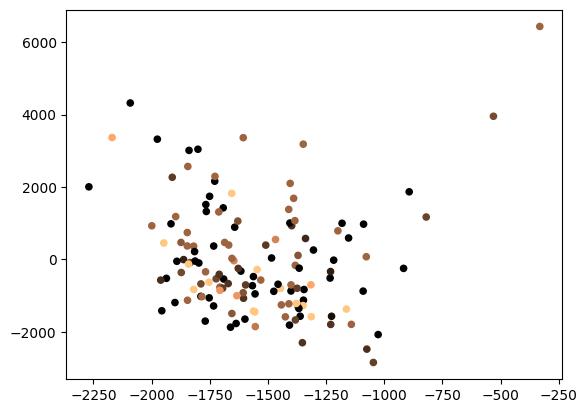

In [15]:
fig, ax = plt.subplots()
ax.scatter(Z_new[:,0], Z_new[:,1], c=pos_scores, cmap=plt.cm.copper, s = 20)
plt.show()

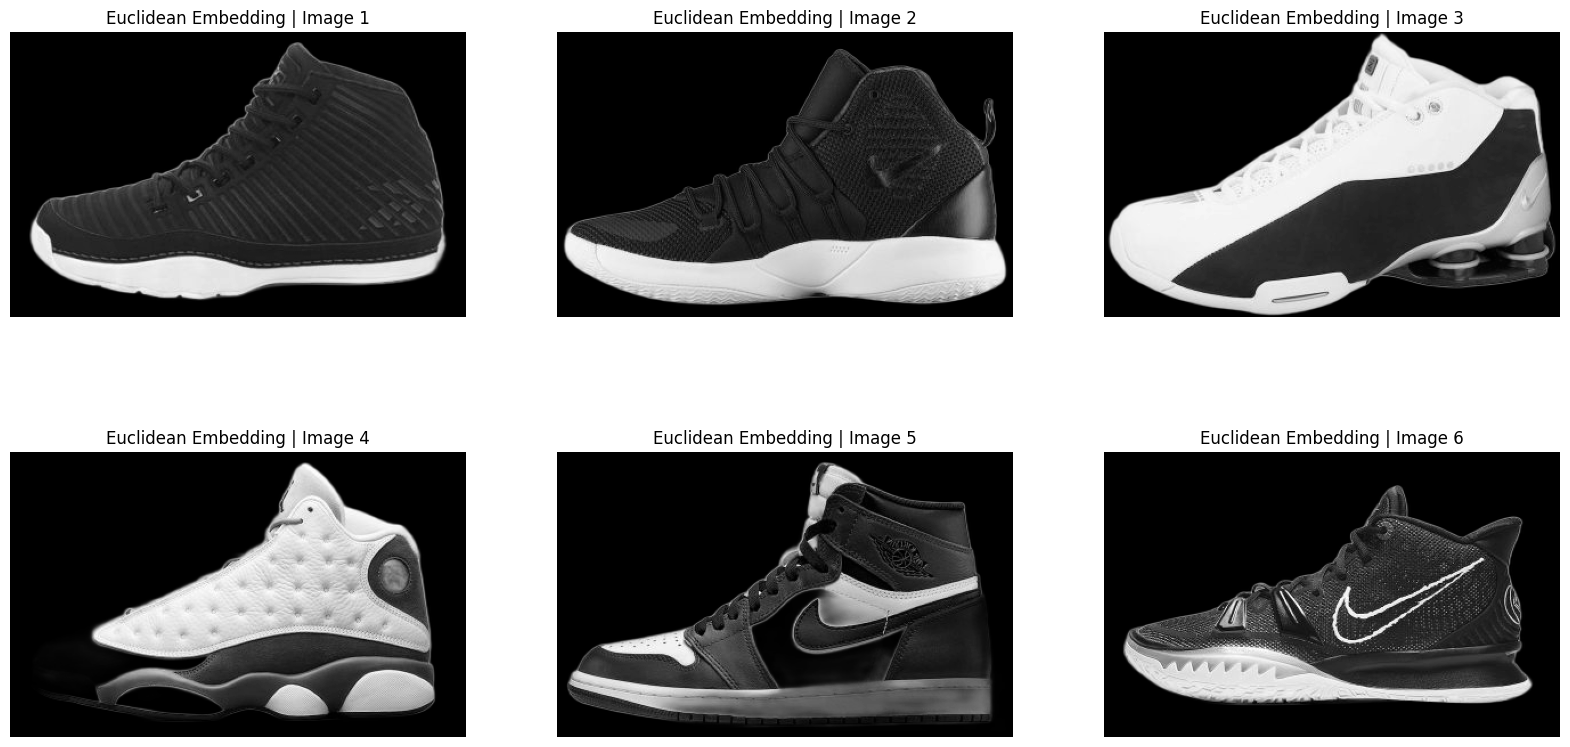

In [16]:
index = np.argsort(Z_new[:,0])[:6]
fig, axs = plt.subplots(2, 3, figsize=(20,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.reshape(images[index[i]], (250,400)), cmap="gray")
    ax.set_title(f'Euclidean Embedding | Image {i+1}')
    ax.axis("off")